## Overview
This notebook demonstrates using likelihood as an index for anomaly detection. Considering a synthetic dataset with 16 variables as an example, which represents the status under normal operating conditions (NOC). A Bayesian network (BN) is employed to describe the relationships among variables, where a BN can be learned either from data or predefined by domain knowledge. Give a BN $\mathcal{G}$, The joint probability distribution can be expressed by the product of the local probability distribution $Pr(X_1, X_2, ..., X_K) = \prod_{k=1}^{K} Pr(X_k|\mathbb{X}_{\text{pa}(k)})$, where $\mathbb{X}_{\text{pa}(k)}$ are the parents of variable $X_K$ in $\mathcal{G}$.

To learn a BN strcuture from data $\mathcal{D}$, one type of approach is called "score-based algorithm", where the idea is to find a structure that best describes the data. Some popular object functions, such as BIC, AIC, are based on the likelihood function. For example, 
$BIC(\mathcal{G}:\mathcal{D}) = log(L) - \frac{d_{\mathcal{G}}}{2}(log N)$, where $L = p(\mathcal{D}|\mathcal{G}, \theta_{\mathcal{G}})$ is the likelihood of the data given structure $\mathcal{G}$ and the maximum likelihood estimation (MLE) $\theta_{\mathcal{G}}$, and $d_{\mathcal{G}}$ is the model complexity of $\mathcal{G}$.

Now, we extend the idea of using the likelihood function to describe the fitness of data given a model for a BN-based monitoring scheme. The status of each node (variable) is monitored based on its local log-likelihood value (later referred to as local likelihood for simplification). To set up the distribution of local likelihood under NOC, each single data point from the training data is used to construct a distribution. Then, the control limits for each node are determined based on the probability density function. When a new data point is collected, the likelihood value is calculated and compared to the CL.

Since the joint probability distribution can be expressed by the product of the local probability distribution. A global likelihood index is also developed that sums all local possibilities to monitor the overall status.


In [1]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


## (1) Load dataset

The following synthetic dataset is generated based on a causal network proposed by Tamda et al. (2003).

In [2]:
df = pd.read_csv("data/gene_data_train.csv")
print(df.shape)
df.head()

(1000, 16)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,2.442848,1.687888,0.469727,2.036935,0.338513,1.296362,2.295771,0.363421,-0.106631,1.407895,0.596148,0.358668,0.497722,1.165225,0.841043,0.203415
1,3.334706,1.480571,0.885413,2.340743,0.626904,2.188196,1.915579,1.242122,0.756687,1.649212,0.724354,0.210039,1.273396,1.383854,1.167070,0.010035
2,-0.403231,-0.448922,0.013330,0.912262,0.104885,-0.127585,-0.718686,-1.264042,0.966555,0.590284,0.471497,-0.237898,-0.028427,0.999798,-0.063783,-0.251955
3,2.924908,1.871368,0.717134,2.553759,0.461372,1.823811,2.409575,0.886211,0.180740,1.166210,0.622089,0.182978,0.745579,1.248753,1.089831,-0.462595
4,4.074106,2.434649,1.047314,2.398894,0.751044,2.761664,3.423753,1.352372,0.564267,1.572461,0.748105,0.983673,1.465964,1.430766,1.277524,0.757766


In [3]:
nodes = df.columns.values
print(nodes)

['X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9' 'X10' 'X11' 'X12' 'X13'
 'X14' 'X15' 'X16']


## (2) BN structure

- **Learn bn structure using bnlearn**

In [4]:
# Import r package
pandas2ri.activate()
bnlearn = importr("bnlearn")

# Hill climbing algorithm (optional arguments: restart , perturb)
bn_r = bnlearn.hc(df) 

# Convert R object to Python dictionary
bn_pd = ro.conversion.rpy2py(bn_r)
bn = dict(zip(bn_pd.names, map(list,list(bn_pd))))

# Extract edges
edges = bn['arcs']
edges = (np.asmatrix(edges).reshape(2,-1)).T.tolist()
print(f"Number of edges: {len(edges)}")   

Number of edges: 19


- **Create DiGraph objects**

In [5]:
# Learned structure (the structure learned from data)
learn_g = nx.DiGraph()
learn_g.add_nodes_from(nodes)
learn_g.add_edges_from(edges)

# True structure (the structure used to generate data)
true_network_edges = pd.read_csv("data/gene_edges.csv")
true_g = nx.DiGraph()
true_g.add_nodes_from(nodes)
true_g.add_edges_from(np.array(true_network_edges))

- **Compare learned strucutre with true structure**

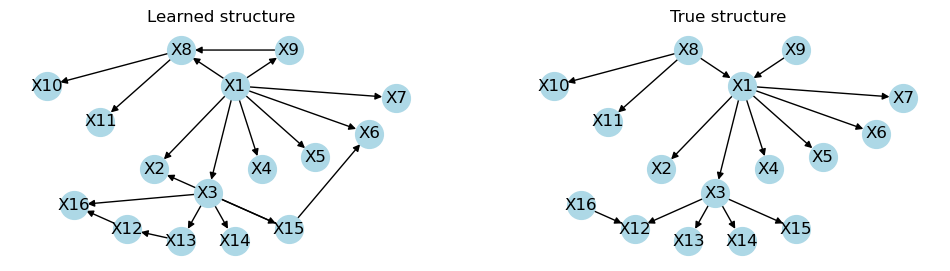

In [6]:
custom_pos ={'X1':[0.5, 0.8],'X2':[0.35, 0.45],'X3':[0.45, 0.35],'X4':[0.55, 0.45],'X5':[0.65, 0.5],'X6':[0.75, 0.6],'X7':[0.8, 0.75],'X8':[0.4, 0.95],
        'X9':[0.6, 0.95],'X10':[0.15, 0.8],'X11':[0.25, 0.65],'X12':[0.3, 0.2],'X13':[0.4, 0.15],'X14':[0.5, 0.15],'X15':[0.6, 0.2],'X16':[0.2, 0.3]}

fig, ax = plt.subplots(1, 2, figsize = (12, 3))
nx.draw(learn_g, custom_pos, with_labels = True, node_color='lightblue', node_size = 400, ax = ax[0])
nx.draw(true_g, custom_pos, with_labels = True, node_color='lightblue', node_size = 400, ax = ax[1])

ax[0].set_title("Learned structure")
ax[1].set_title("True structure");

## (3) Functions for likelihood monitoring

In [7]:
from scipy import stats
from sklearn.linear_model import LinearRegression
import math

In [8]:
def value_to_lik(node_value, node_mean, node_var):
    """
    Calculate the log-likelihood of a given value under a normal distribution.

    Parameters:
    - node_value (float): The observed value.
    - node_mean (float): The mean of historical data.
    - node_var (float): The variance of historical data.

    Returns:
    - ln_lik (float): The log-likelihood of the observed value.
    """
    
    ln_lik = -(1/2)*np.log(2*math.pi) - (1/2)*np.log(node_var) - (1/(2*node_var))*((node_value-node_mean)**2)

    return ln_lik

In [9]:
def get_local_data(g, data, target):
    """
    Get local data for a node in a Bayesian network.

    For a root-node variable, the local data refers to the original data of the variable.
    For a non-root-node variable, the local data is the residuals after regressing the target variable on its parents.

    Parameters:
    - g (NetworkX DiGraph): The Bayesian network graph.
    - data (DataFrame): The dataset containing all variables.
    - target (str): The name of the target variable.

    Returns:
    - list: If the node is a root node, returns the original data of the variable as a list. 
      Otherwise, returns the residual data as a list.
    - LinearRegression or None: If the node is a root node, returns None. 
      Otherwise, returns the fitted linear regression model.
    """
    parents = [pa for pa in g.predecessors(target)]
    
    if len(parents) == 0:
        local_data = data[target].tolist()  # Extract the original data
        lm = None  # Since it's a root node, return None for the model
        return local_data, lm
        
    else:
        X = data[parents]
        Y = data[[target]]
        lm = LinearRegression()
        lm.fit(X, Y)
        pred = lm.predict(X)
        resid_df = Y - pred
        local_data = resid_df.iloc[:, 0].tolist()  # Extract the residuals
        return local_data, lm


In [10]:
def get_CL(x, alpha=0.01):
    """
    Calculate the probability density function (pdf) and control limits (LCL) for a given dataset using kernel density estimation (KDE).
    
    Parameters:
        x (list): 1-D array input data.
        alpha (float, optional): Significance level for determining control limits. Default is 0.01.
    Returns:
        tuple: Tuple containing:
            - prob (Series): Probability density function values.
            - LCL (float or None): Lower control limit value.
    """
    # Calculate minimum and maximum values of the input data
    min_x = min(x)
    max_x = max(x)
    x_range = max_x - min_x
    
    # Extend the range by 50% to set bounds for kernel density estimation
    upper = max_x + 0.5 * x_range
    lower = min_x - 0.5 * x_range
    
    # Estimate the probability density function using Gaussian KDE
    mykde = stats.gaussian_kde(x)
    
    # Generate equally spaced points and compute the probability density function values
    x_d = np.linspace(lower, upper, 10000)
    pdf_values = pd.Series(mykde.pdf(x_d), index = x_d, name = "Probability Density")

    # Calculate the cumulative distribution function (CDF) and determine control limit
    cum_cdf = [mykde.integrate_box_1d(lower, i) for i in x_d]
    LCL_diff = [abs(cum - alpha) for cum in cum_cdf]
    LCL_idx = LCL_diff.index(min(LCL_diff))
    LCL = x_d[LCL_idx]


    return pdf_values, LCL

In [11]:
def plot_lik_distribution(data_values, pdf_values= None, LCL= None, new_value = None):
    """
    Plot the likelihood distribution along with optional PDF values, control limits, and new data point.

    Parameters:
    - x (list): The historical likelihood values.
    - pdf_values (Pandas Sereis, optional): The probability density function values. Default is None.
    - LCL (float, optional): The Lower Control Limit. Default is None.
    - new_value (float, optional): The likelihood value of new data. Default is None.

    Returns:
    - None
    """
    fig, ax1 = plt.subplots(figsize=(8, 3))
    ax1.hist(data_values, color = "cornflowerblue", label = "Historical likelihood values")
    ax1.set_ylabel("Likelihood")
    
    if pdf_values is not None:
        ax2 = ax1.twinx()
        ax2.plot(pdf_values, color = "darkblue", label = "Probability Density")
        ax2.set_ylim(bottom=0)
        ax2.set_ylabel("Probability Density")
    
    if LCL is not None:
        ax1.axvline(x=LCL, color='red', linestyle='--', label='LCL')
        
    if new_value is not None:
        ax1.axvline(x=new_value, color='green', linestyle='--', label='Likelihood value of new data')

    ax1.legend(loc='upper left')  

    return ax1

## (4) Likelihood monitoring

### (4.1) Local likelihood distribution for individual node
- **Step1**: Convert the variable values to likelihood values. (For variables with parent nodes, use the residual as the variable value.)
- **Step2**: Estimate the probability density function using Gaussian KDE.
- **Step3**: Setup control limit based on estimated pdf. (Likelihood aims high, so only LCL is needed)
- **Step4**: Test if a new data point is within control limit.

#### (4.1.1) Example-1: X9 (Root node)

In [12]:
# Step1: Convert the variable values to likelihood values.
X9_data, lr_X9 = get_local_data(g = true_g, data = df, target = "X9")
X9_mean = np.mean(X9_data)
X9_var = np.var(X9_data)
X9_lik = [value_to_lik(x, X9_mean, X9_var) for x in X9_data]

print(f"Data length: {len(X9_lik)}")

Data length: 1000


In [13]:
# Step2: Estimate the probability density function using Gaussian KDE.
# Step3: Setup control limit based on estimated pdf. (Likelihood aims high, so only LCL is needed)
X9_pdf, X9_LCL = get_CL(X9_lik)
print(f"LCL: {X9_LCL:.2f}")

LCL: -4.35


<Axes: ylabel='Likelihood'>

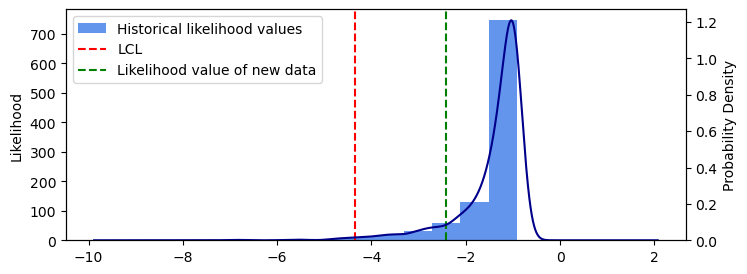

In [14]:
# Step4: Test if a new data point is within control limit.
new_x9 = 1.738
new_lik_x9 = value_to_lik(new_x9, X9_mean, X9_var)

plot_lik_distribution(data_values = X9_lik, pdf_values = X9_pdf, LCL= X9_LCL, new_value = new_lik_x9)

#### (4.1.2) Example-2: X1 (Non-root node)

In [15]:
# Step1: Convert the variable values to likelihood values.
X1_data, lr_X1 = get_local_data(g = true_g, data = df, target = "X1")
X1_mean = np.mean(X1_data)
X1_var = np.var(X1_data)
X1_lik = [value_to_lik(x, X1_mean, X1_var) for x in X1_data]

print(f"Data length: {len(X1_lik)}")

Data length: 1000


In [16]:
# Step2: Estimate the probability density function using Gaussian KDE.
# Step3: Setup control limit based on estimated pdf. (Likelihood aims high, so only LCL is needed)
X1_pdf, X1_LCL = get_CL(X1_lik)
print(f"LCL: {X1_LCL:.2f}")

LCL: -3.27


<Axes: ylabel='Likelihood'>

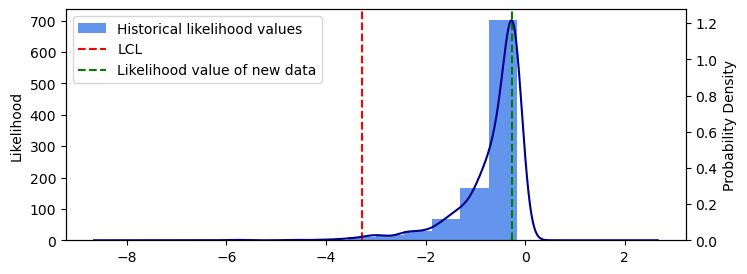

In [17]:
# Step4: Test if a new data point is within control limit.
new_x1 = 0.213
new_lik_x1 = value_to_lik(new_x1, X1_mean, X1_var)

plot_lik_distribution(data_values = X1_lik, pdf_values = X1_pdf, LCL= X1_LCL, new_value = new_lik_x1)

### (4.2) Global likelihood distribution of the entire network
- **Step1**: Calculate likelihood values for each variable. (For variables with parent nodes, use the residual to calculate likelihood.)
- **Step2**: Sum all local likelihood values into global likelihood value.
- **Step3**: Estimate the probability density function using Gaussian KDE.
- **Step4**: Setup control limit based on estimated pdf. (Likelihood aims high, so only LCL is needed)
- **Step5**: Test if a new data point is within control limit.

In [18]:
# Step1: Calculate likelihood values for each variable. (For variables with parent nodes, use the residual to calculate likelihood.)

lik_dict = {}
local_distribuion = {}

for node in nodes:
    local_data, lr_model = get_local_data(g = true_g, data = df, target = node)
    local_mean = np.mean(local_data)
    local_var = np.var(local_data)  

    # Calculate likelihood
    local_lik = [value_to_lik(x, local_mean, local_var) for x in local_data]
    lik_dict[node] = local_lik

    # For later monitor new data
    local_distribuion[node] = {"mean": local_mean, "var": local_var, "regression_model": lr_model}


local_lik_df = pd.DataFrame(lik_dict)
local_lik_df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,-2.260733,0.013119,0.670410,0.699317,0.520855,0.181331,-1.417797,-0.923700,-0.924698,-1.035214,2.078954,0.439896,0.707362,2.043232,0.039318,-0.929519
1,-0.315484,-1.250544,0.916718,0.752876,1.582254,0.056955,-0.674136,-1.613183,-1.196241,0.386827,2.034080,-0.047389,0.708478,1.991756,0.995307,-0.911044
2,-0.207951,0.028640,1.188991,0.650199,0.607618,0.225947,-0.676722,-1.853382,-1.375138,0.851137,-0.376528,0.445050,0.997855,2.174155,0.734226,-0.946614
3,-0.479706,0.242998,1.314788,-1.337551,1.252462,0.268254,-0.391870,-1.233246,-0.932131,0.090978,1.000270,0.182332,0.109928,1.793514,0.606442,-1.025783
4,-0.645591,0.347326,0.939992,-0.025607,1.550371,-0.373599,-1.299553,-1.758681,-1.071016,1.102979,2.094808,0.243656,0.814247,2.159304,0.707342,-1.193035


In [19]:
# Step2: Sum all local likelihood values into global likelihood value.
global_lik = local_lik_df.sum(axis = 1)
global_lik.shape

(1000,)

In [20]:
# Step3: Estimate the probability density function using Gaussian KDE.
# Step4: Setup control limit based on estimated pdf. (Likelihood aims high, so only LCL is needed)
global_pdf, global_LCL = get_CL(global_lik)
print(f"LCL: {global_LCL:.2f}")

LCL: -6.52


<Axes: ylabel='Likelihood'>

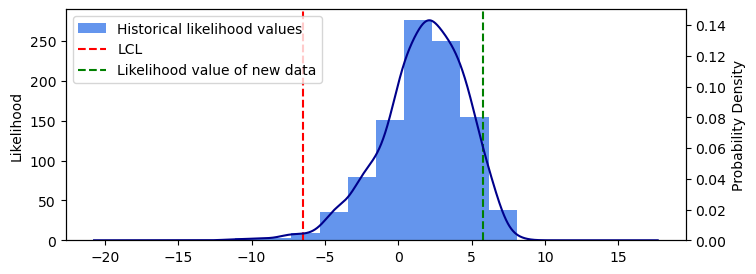

In [21]:
# Step4: Test if a new data point is within control limit.

idx = 10
new_row = df.iloc[idx,:] # Randomly select a row as new data row


new_gb_lik = 0

for node, value in new_row.items():
    node_mean = local_distribuion[node]["mean"]
    node_var = local_distribuion[node]["var"]
    node_lr = local_distribuion[node]["regression_model"]

    if node_lr is None: # Root-node
        node_value = value
        
    else: # Non-root-node
        parents = [pa for pa in true_g.predecessors(node)]
        parents_data = new_row[parents].to_frame().transpose()
        resid = node_lr.predict(parents_data) - value
        node_value = resid
            
    new_lik = value_to_lik(node_value, node_mean, node_var)
    
    new_gb_lik += new_lik


plot_lik_distribution(data_values = global_lik, pdf_values = global_pdf, LCL= global_LCL, new_value = new_gb_lik)